# Estacionalidad

## ¿Qué es la estacionalidad?

Se dice que una serie temporal exhibe estacionalidad siempre que haya un cambio regular y periodico en la media de la serie. Generalmente, los cambios estacionales siguen el reloj y el calendario. Son comunes las repeticiones en un día, una semana o un año. La estacionalidad suele estar dirigida por los ciclos del mundo natural durante días y años o por convenciones de comportamiento social en torno a fechas y horas.

![patrones de estacionalidad](./images/patrones_estacionalidad.png)

Veremos que hay dos tipos de variables que modelan la estacionalidad. El primer tipo, los indicadores, es mejor para una estacionalidad con pocas observaciones, como estacionalidad semanal de observaciones diarias. El segundo tipo, variables Fourier, es mejor para una estacionalidad con muchas observaciones, como estacionalidad anual de observaciones diarias.

## Gráficas de estacionalidad e indicadores de estacionalidad

Al igual que usamos una gráfica de media móvil para descubrir la tendencia en un serie, podemos usar una **gráfica estacional** para descubrir patrones estacionales.

Una gráfica estacional muestra segmentos de la serie temporal representados en un periodo común, siento el periodo la "estación" que queremos observar. La siguiente figura muestra una gráfica estacional de las vistas diarias del artículo de Wikipedia sobre *Trigonometría*: las vistas diarias del artículo dibujadas sobre un periodo semanal común. En ella se puede observar claramente un patrón estacional semanal, más grande entre semana y descendente hacia el fin de semana.

![season_trigonometry](./images/season_trigonometry.png)

### Indicadores estacionales

Los **indicadores estacionales** son features binarias que representan diferencias estacionales en el nivel de una serie temporal. Los indicadores estacionales son lo que obtenemos si tratamos un periodo estacional como una variable categórica y le aplicamos codificación *one-hot*.

Al codificar one-hot los días de la semana, obtenemos indicadores estacionales semanales. La creación de indicadores semanales para la serie *Trigonometría* nos proporcionará seis nuevas features "dummy". (La regresión lineal trabaja mejor si eliminamos unos de los indicadores; elegimos el lunes en la tabla siguiente.)

![one_hot_trigonometry](./images/one_hot_trigonometry.png)

Añadir los indicadores estacionales a los datos de entrenamiento ayuda a los modelos a distinguir medias dentro de un periodo estacional:

![linear_regresion_estacionalidad](./images/estacionalidad_linear_regresion.png)

Los indicadores actúan como interruptores encendido/apagado. En cualquier momento, como máximo uno de esos indicadores puede tener un valor de 1 (*encendido*). La regresión lineal aprende un valor de línea base de `2379` para `Mon` y luego lo ajusta según el valor de si el indicador está *encendido* para ese día; el resto son `0` y desaparecen.

### Variable Fourier y el Periodograma

Este tipo de features es más apropiada para grandes estacionalidades en muchas observaciones, donde los indicadores serían impracticables. En lugar de crear una variable para cada fecha, las features Fourier intentar capturar la forma global de la curva estacional con solo unas pocas features.

Echemos un vistazo al gráfico de la estacionalidad anual de *Trigonometría*. Observemos las repeticiones de varias frecuencuas:  un movimiento largo ascendente y descendente tres veces al año, movimientos cortos semanales 52 veces al año y tal vez otros.

![fourier_trigonometria](./images/fourier_trigonometria.png)

Estas son las frecuencias dentro de una estación que intentamos capturar con las features Fourier. La idea es incluir en nuestros datos de entrenamiento curvas periodicas que tengan las mismas frecuencias que la estación que estamos intentando modelar. Las curvas que utilizamos son las de las funciones seno y coseno.

Las **features Fourier** son pares de curvas seno y coseno, un par para cada potencial frecuencia en la estación empezando con la más larga. Los pares de Fourier que modelan la estacionalidad anual tendrían frecuencias: una vez al año, dos veces por año, tres veces por año y así sucesivamente.

![fourier_pares](./images/fourier_pares.png)

En la figura anterior se muestras los primeros dos pares Fourier para la estacionalidad anual. En la parte superior, frecuencia de una vez por año. En la parte inferior, frecuencia de dos veces por año.

Si añadimos un conjunto de estas curvas seno/coseno a nuestros datos de entrenamiento, el algoritmo de regresión lineal averiguará los pesos que ajustarán el componente estacional en la serie objetivo. La siguiente figura ilustra cómo la regresión lineal uso cuatro pares Fourier para modelar la estacionalidad anual en la serie *Trigonometría de la wiki*.

![trigonometria_pares_fourier](./images/fourier_pairs_trigonometria.png)

En la parte superior, las curvas de cuatro partes, una suma de senos y cosenos con coeficientes de regresión. Cada curva modela una frecuencia diferente. En la parte inferior, la suma de esas curvas aproxima el patrón estacional.

Tengamos en cuenta que solo necesitamos ocho features (cuatro pares seno/coseno) para obtener una buena estimación de la estacionalidad anual. Comparemos esto con el método de indicadores estacionales, que habría requerido cientos de features (una por cada día del año). Al modelar solo el "efecto pincipal" de la estacionalidad con features Fourier, normalmente necesitaremos añadir muchas menos funciones a los datos de entrenamiento, lo que reduce el tiempo computacional y disminuye el riesgo de overfitting.

#### Elegir features Fourier con el Periodograma

¿Cuántos pares Fourier se deben añadir realmente en nuestro conjunto de features? Podemos responder esta pregunta con el periodograma. El **periodograma** nos dice la fortaleza de las frecuencias de un serie temporal. Específicamente, el valor del eje y del gráfico es `(a ** 2 + b ** 2) / 2`, donde `a` y `b` son los coeficientes del seno y coseno en esa frecuencia (como vimos en el grafico anterior).

![periodograma](./images/periodograma.png)

De izquierda a derecha, el periodograma cae después trimestral, cuatro veces al año. Por eso elegimos cuatro pares Fourier para modelas la estacionalidad anual. La frecuencia semanal la ignoramos, dado que es mejor modelarla con indicadores.

#### Calculo de las features Fourier

Saber cómo se calculan las features Fourier no es esencial para saber usarlas, pero si se ven los detalles se pueden aclarar cosas. A continuación se muestra como se pueden derivar un conjunto de features Fourier del índice de una serie temporal. Sin embargo, para nuestros ejemplos usaremos una función de `statsmodels`.

In [39]:
import numpy as np
import pandas as pd

def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)


# Calcula features Fourier de 4º orden (8 nuevas features) para una
# serie y con observaciones diarias y estacionalidad anual:
#
# fourier_features(y, freq=365.25, order=4)

## Ejemplo - Tráfico del Túnel

Utilizaremos el dataset de Tráfico del Túnel. Vamos a definir 2 funciones: `seasonal_plot` y `plot_periodogram`.

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [41]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [42]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Gráfico estacional ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [43]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [44]:
tunnel = pd.read_csv("../data/tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period("D")

Echemos un vistazo al gráfico estacional durante una semana y durante un año.

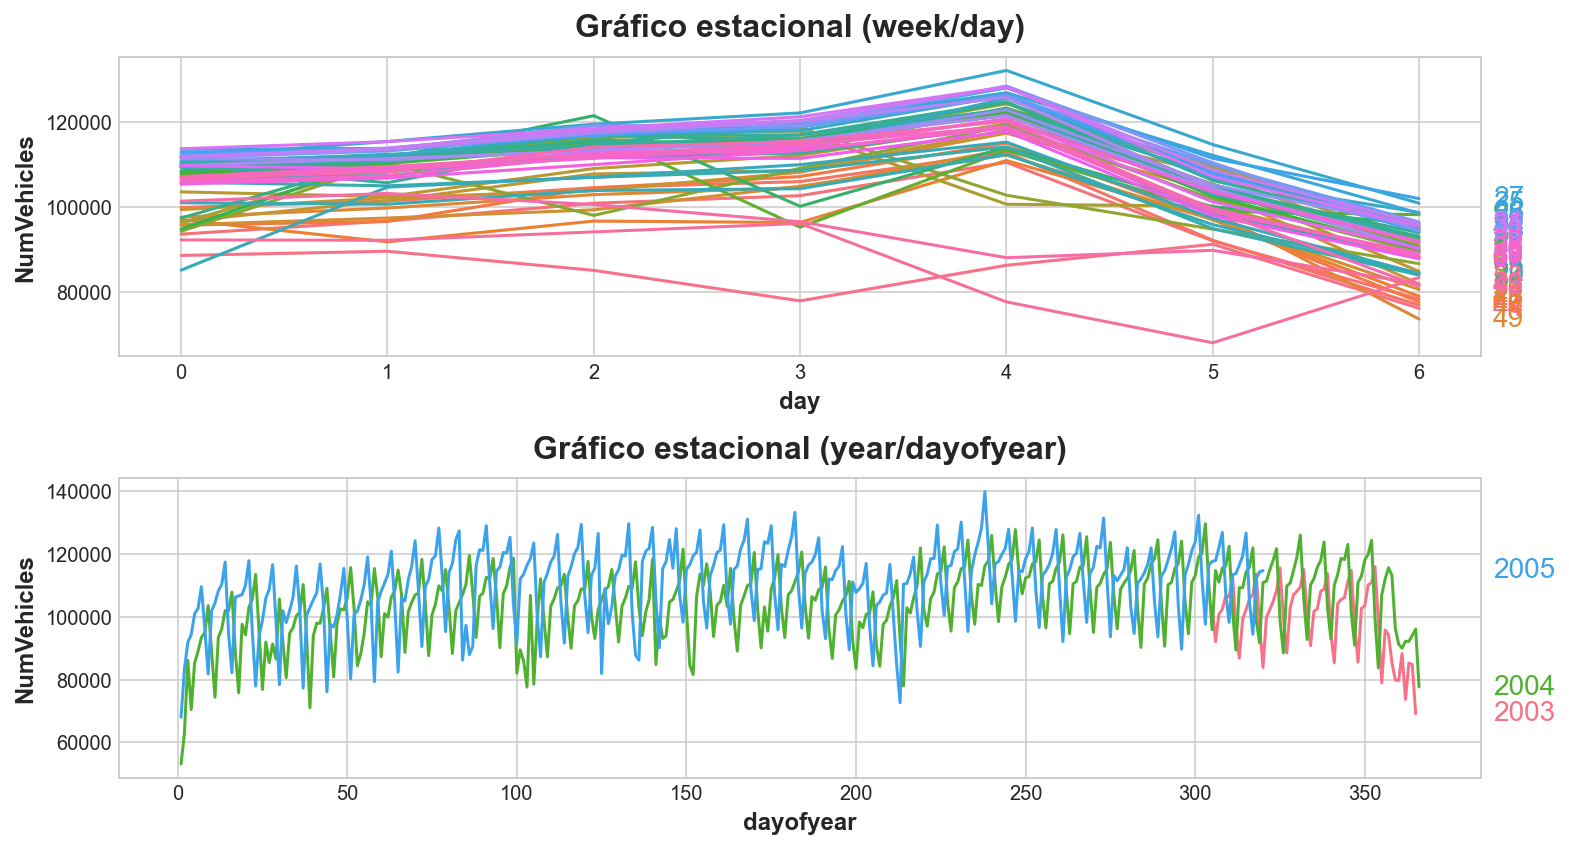

In [45]:
X = tunnel.copy()

# días dentro de una semana
X["day"] = X.index.dayofweek  # eje x (freq)
X["week"] = X.index.week  # periodo estacional (period)

# días dentro de un año
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="NumVehicles", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="NumVehicles", period="year", freq="dayofyear", ax=ax1);

Veamos ahora el periodograma:

C:\Users\futit\AppData\Local\Temp\ipykernel_8772\272637971.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  plot_periodogram(tunnel.NumVehicles);


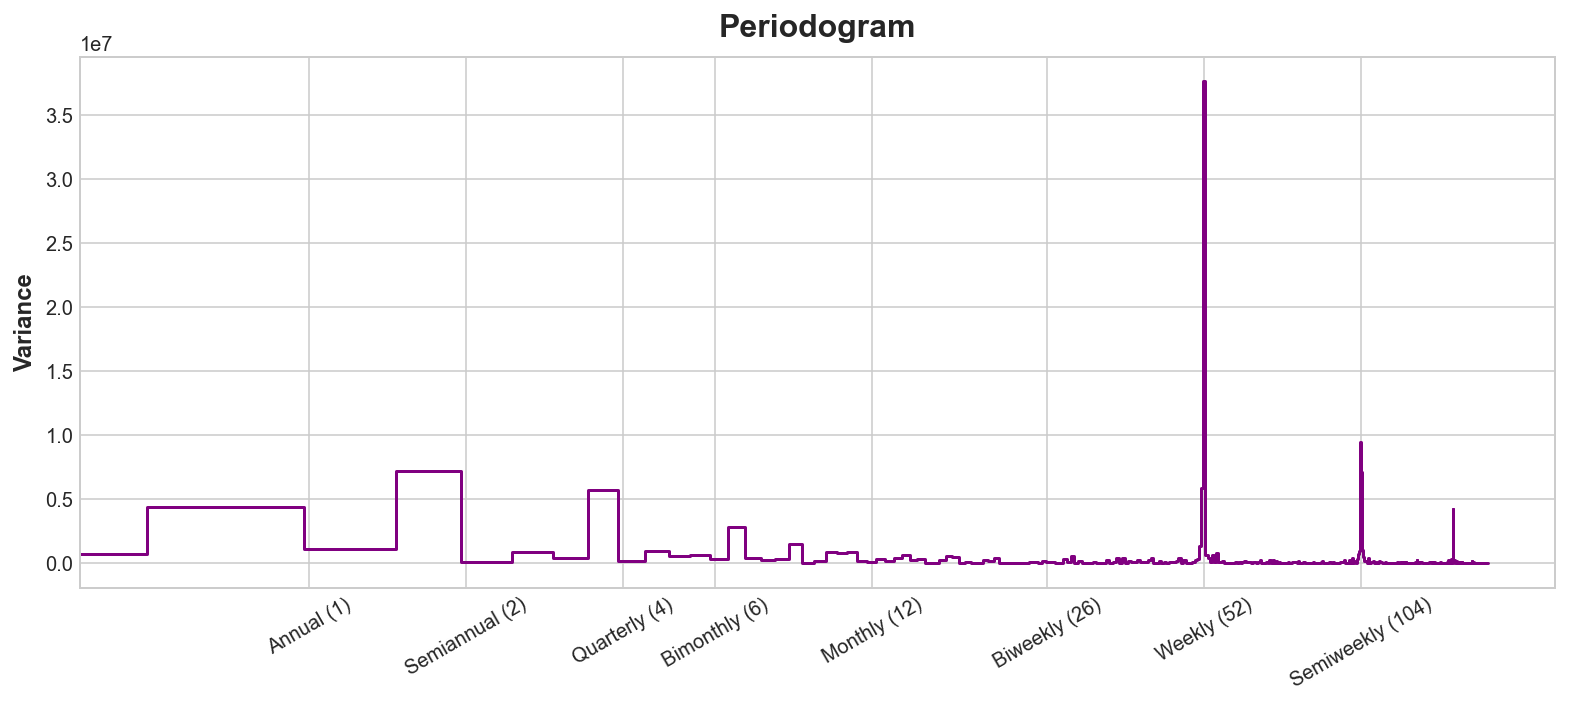

In [46]:
plot_periodogram(tunnel.NumVehicles);

El periodograma concuerda con el gráfico estacional anterior: una fuerte estacionalidad semanal y una estacionalidad anual más débil. La estacionalidad semanal la modelaremos con indicadores y la estacionalidad anual con features Fourier. De derecha a izquierda, el periodograma cae entre entre Semestral (6) y Mensual (12), así que usaremos 10 pares Fourier.

Crearemos nuestras features estacionales usando `DeterministicProcess`, la misma utilidad usada para crear la features de tendencia. Para usar dos periodos estacionales (semanal y anual) necesitaremos instanciar uno de ellos como un "término adicional":

In [47]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 pares seno/coseno para estacionalidad "A"nual

dp = DeterministicProcess(
    index=tunnel.index,
    constant=True,               # feature dummy para bias (y-intercept)
    order=1,                     # tendencia (orden 1 significa lineal)
    seasonal=True,               # estacionalidad semanal (indicadores)
    additional_terms=[fourier],  # estacionalidad anual (fourier)
    drop=True,                   # eliminamos términos para evitar colinealidad
)

X = dp.in_sample()  # crear features para fecha en tunnel.index

In [48]:
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
Day,,,,,,,,,,,,,,,,,,,,,
2003-11-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.867456,0.497513,...,-0.017213,0.999852,-0.875892,0.482508,-0.854322,-0.519744,0.025818,-0.999667,0.880012,-0.474951
2003-11-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.858764,0.512371,...,0.085965,0.996298,-0.811539,0.584298,-0.917584,-0.397543,-0.128748,-0.991677,0.785650,-0.618671
2003-11-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.849817,0.527078,...,0.188227,0.982126,-0.735417,0.677615,-0.963471,-0.267814,-0.280231,-0.959933,0.668064,-0.744104
2003-11-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.840618,0.541628,...,0.288482,0.957485,-0.648630,0.761104,-0.991114,-0.133015,-0.425000,-0.905193,0.530730,-0.847541
2003-11-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.831171,0.556017,...,0.385663,0.922640,-0.552435,0.833556,-0.999991,0.004304,-0.559589,-0.828770,0.377708,-0.925925


Con nuestro conjunto de features creado, estamos listos para entrenar el modelo y hacer predicciones. Añadiremos un pronóstico de 90 días para ver como extrapola nuestro modelo más allá de los datos de entrenamiento.

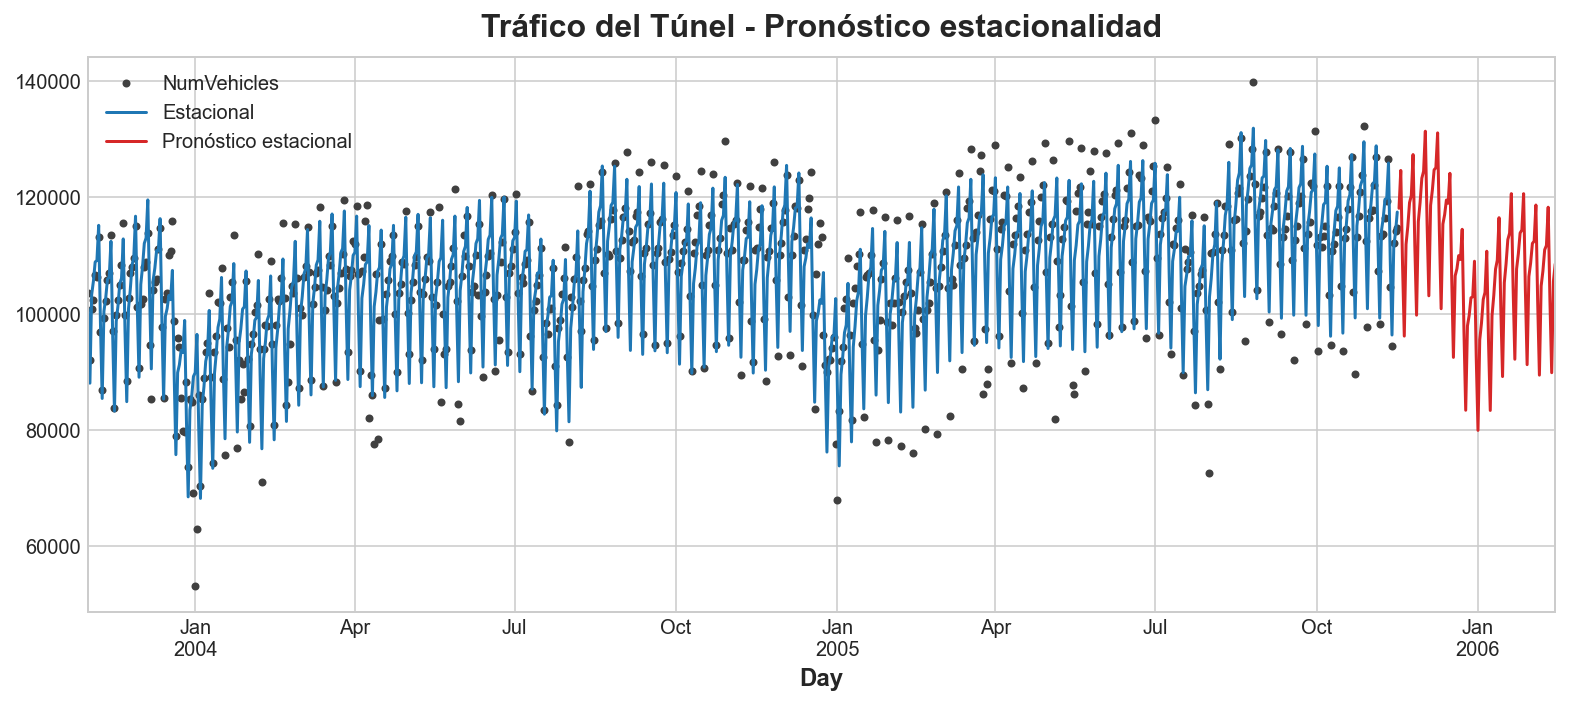

In [49]:
y = tunnel["NumVehicles"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Tráfico del Túnel - Pronóstico estacionalidad")
ax = y_pred.plot(ax=ax, label="Estacional")
ax = y_fore.plot(ax=ax, label="Pronóstico estacional", color='C3')
_ = ax.legend()

# Ejercicio

Vamos a realizar un ejercicio para ampliar lo que acabamos de ver. Para ello cargaremos algunos datasets.

In [50]:
store_sales = pd.read_csv(
    "../data/store_sales/train.csv",
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

In [51]:
average_sales.head()

date
2017-01-01      6.780303
2017-01-02    786.928406
2017-01-03    619.740234
2017-01-04    555.608032
2017-01-05    436.375397
Freq: D, Name: sales, dtype: float32

## Determinar la estacionalidad

Examinemos el siguiente gráfico estacional:

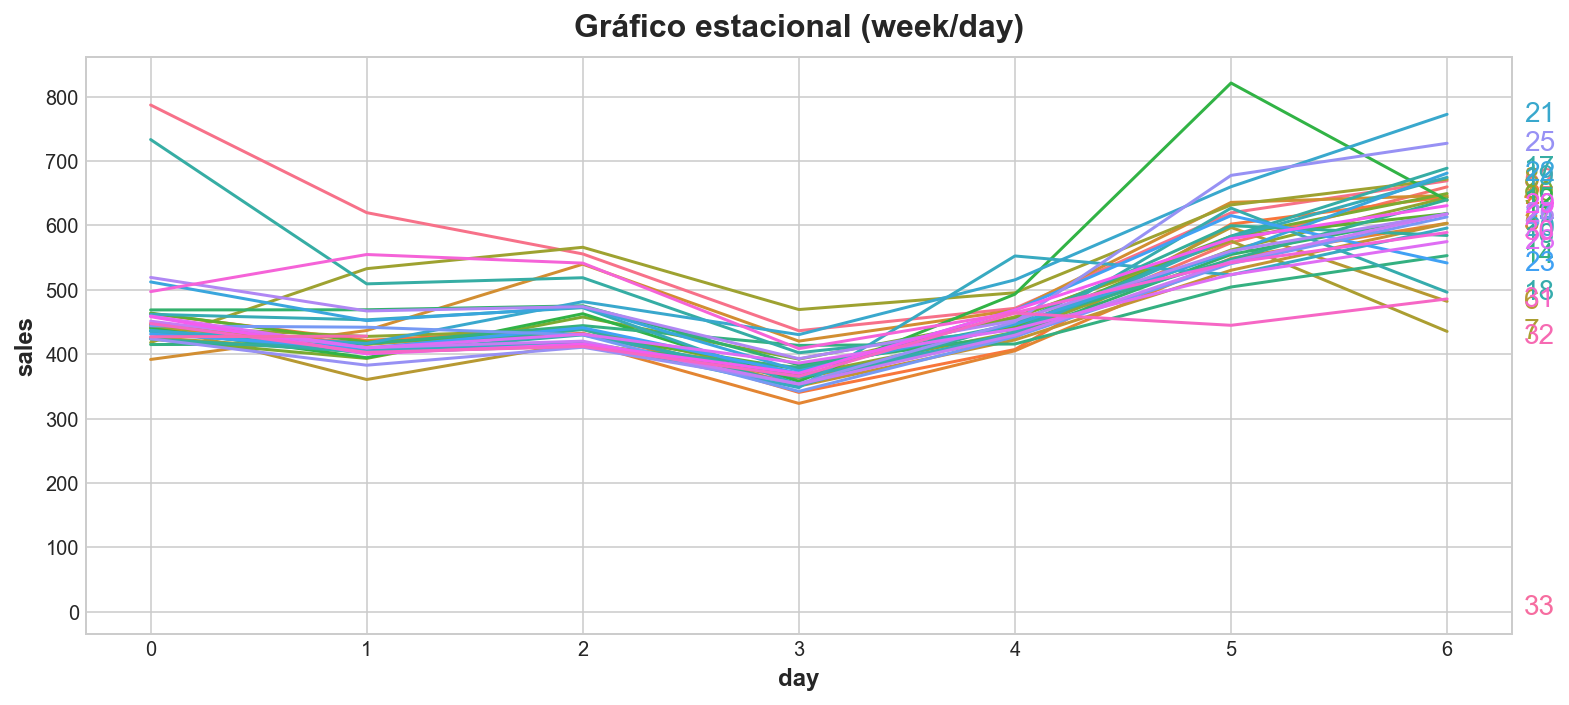

In [52]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

y el periodograma:

C:\Users\futit\AppData\Local\Temp\ipykernel_8772\69537304.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  plot_periodogram(average_sales);


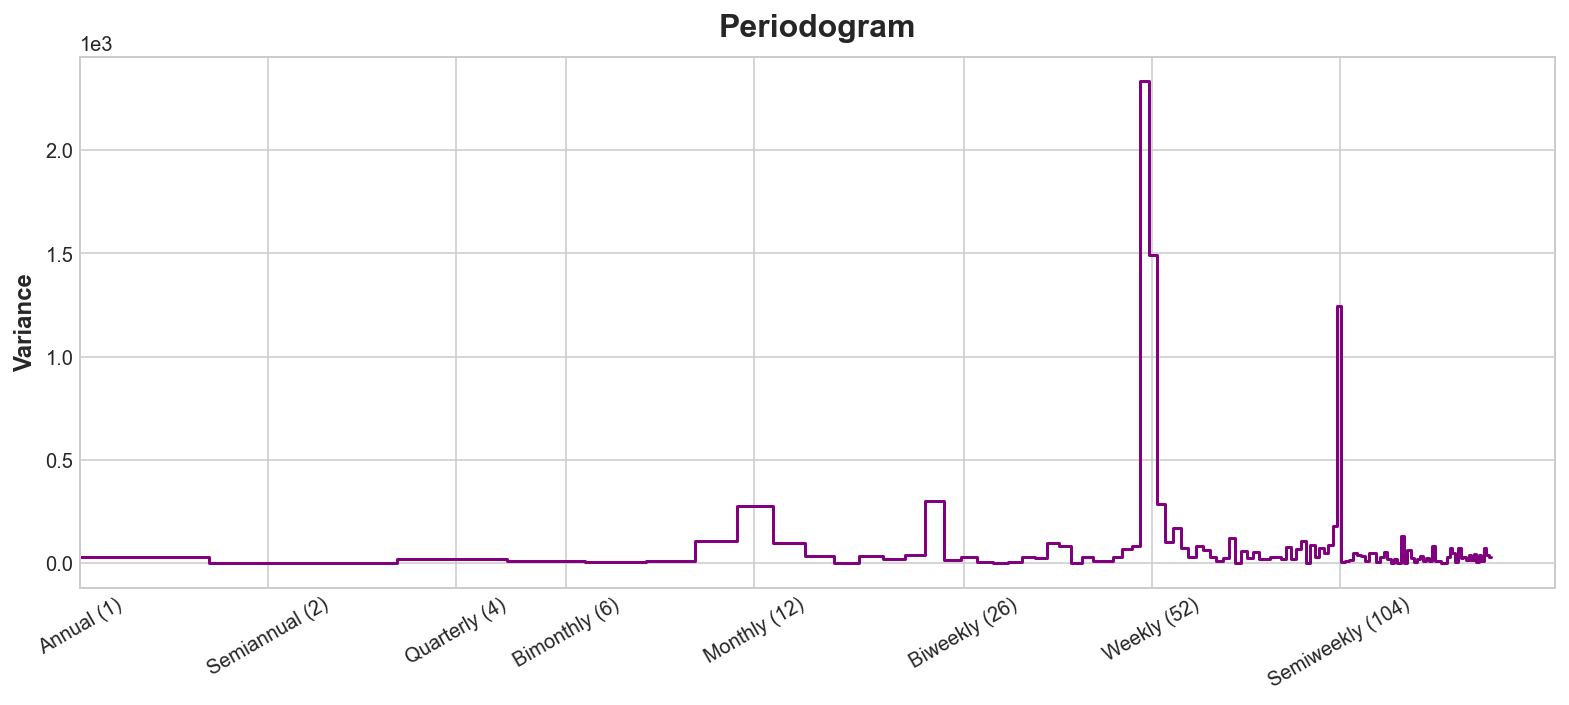

In [53]:
plot_periodogram(average_sales);

**¿De qué tipo de estacionalidad se ve evidencia?**

Ambos gráficos sugieres una fuerte estacionalidad semanal. Del periodograma parece que también puede haber algunos componentes mensuales y bisemanales (quincenales) De hecho, las notas del dataset dicen que los salarios en el sector público se pagan quincenalmente, el 15 y último día de cada mes (un posible origen para esta estacionalidad).

## Crear features estacionales

**Usa `DeterministicProcess` y `CalendarFourier` para crear:**

**+ indicadores para estaciones semanales y**
**+ features Fourier de orden 4 para estaciones mensuales**

In [54]:
y = average_sales.copy()

# YOUR CODE HERE
fourier = CalendarFourier(freq="M", order=4)  # 4 pares seno/coseno para estacionalidad "M"ensual
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

Ahora vamos a entrenar el modelo estacional.

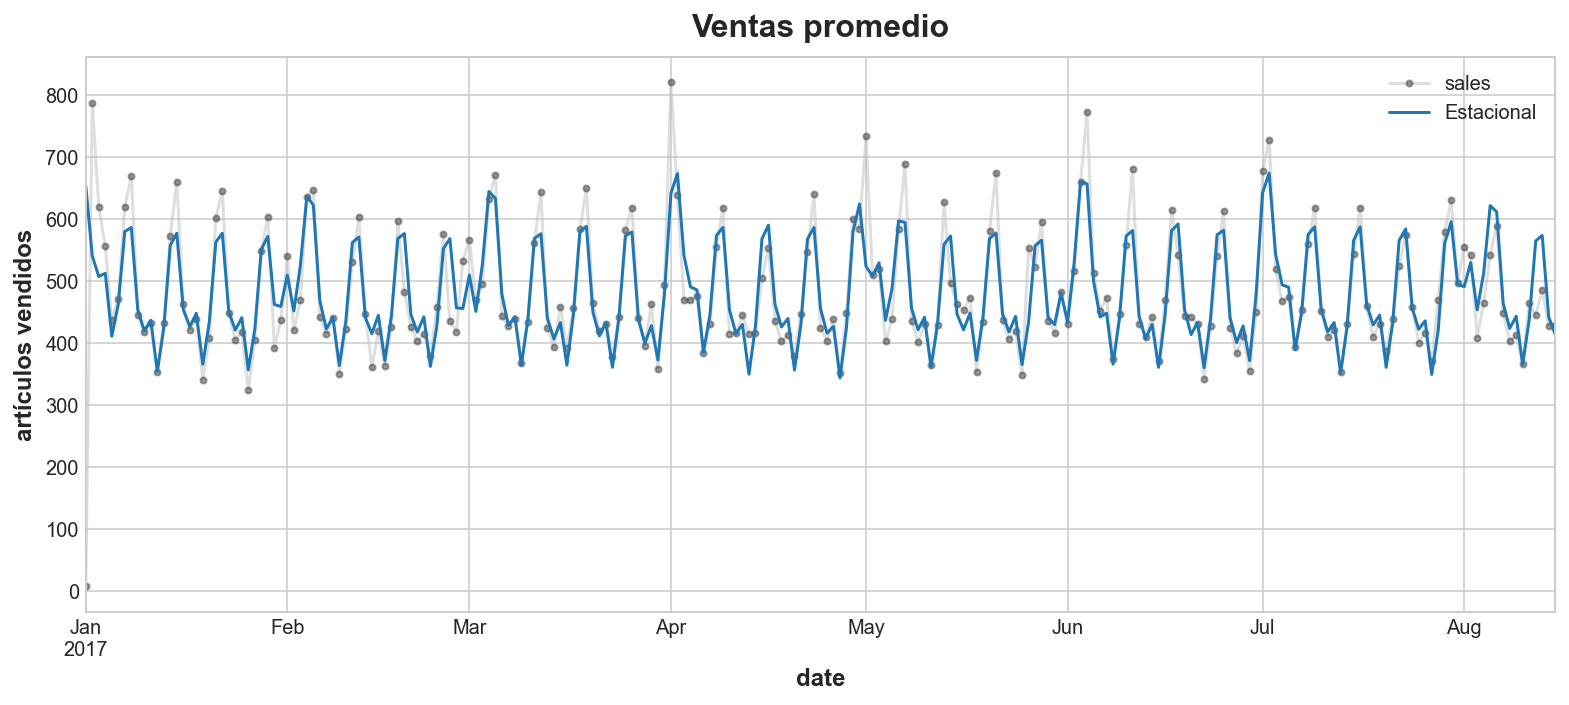

In [55]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, alpha=0.5, title="Ventas promedio", ylabel="artículos vendidos")
ax = y_pred.plot(ax=ax, label="Estacional")
ax.legend();

## Comprobar la estacionalidad restante

Eliminar de una serie su tendencia o estacionalidad se denomina "*detrending*" o "desestacionalizar" la serie. Observemos el periodograma de la serie desestacionalizada.

C:\Users\futit\AppData\Local\Temp\ipykernel_8772\3088312804.py:4: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  ax1 = plot_periodogram(y, ax=ax1)
C:\Users\futit\AppData\Local\Temp\ipykernel_8772\3088312804.py:6: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  ax2 = plot_periodogram(y_deseason, ax=ax2)


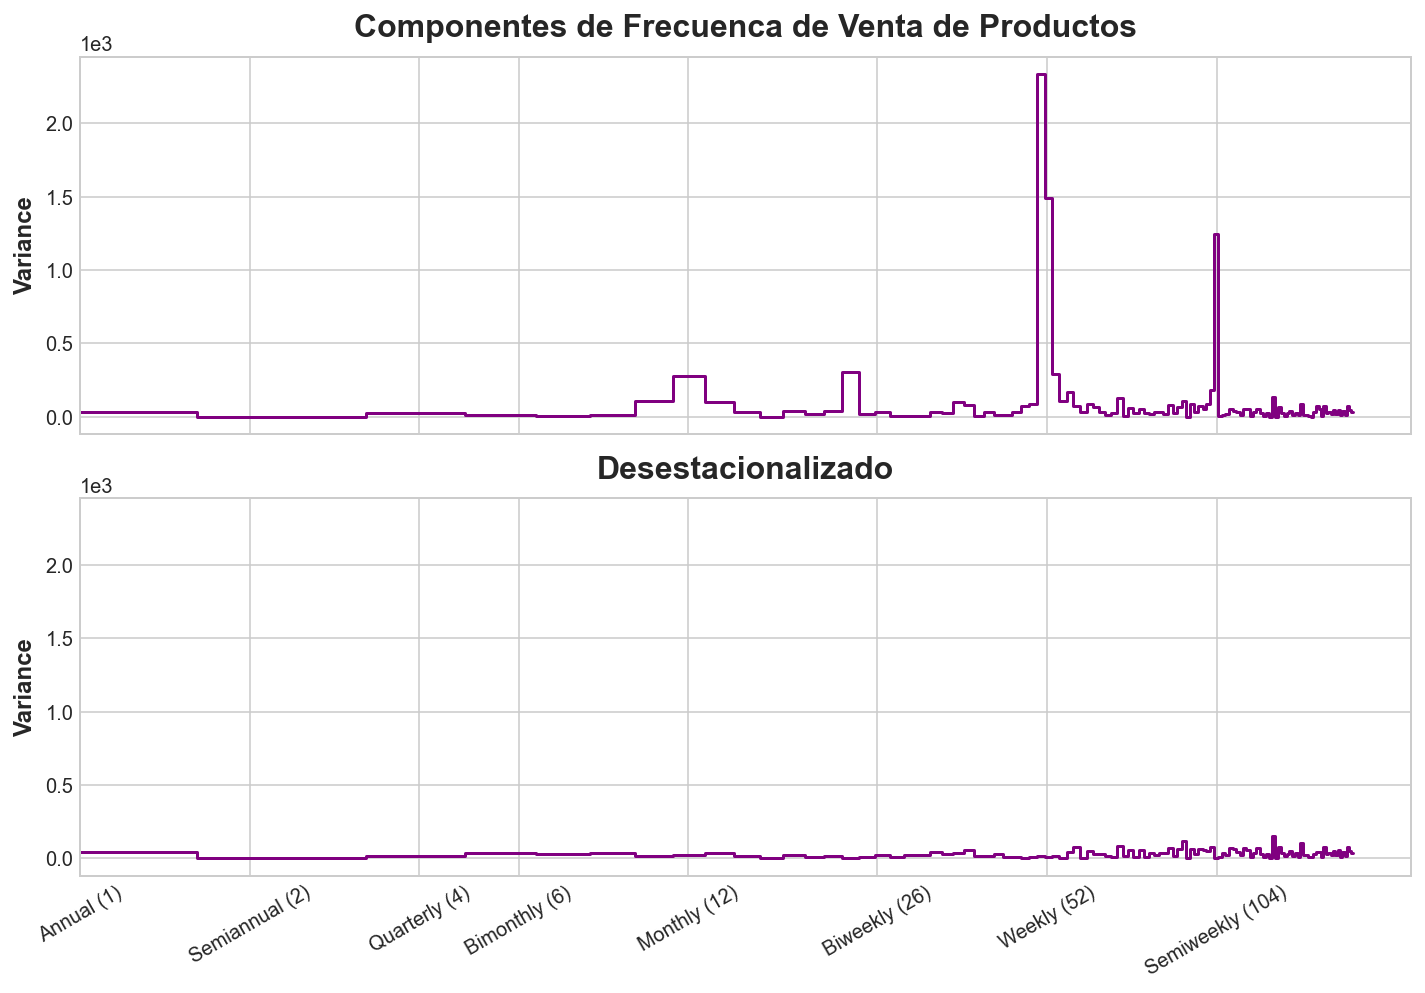

In [56]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Componentes de Frecuenca de Venta de Productos")
ax2 = plot_periodogram(y_deseason, ax=ax2)
ax2.set_title("Desestacionalizado");

**Basándonos en estos periodogramas, ¿cómo de efectivo parece que nuestro modelo capturó la estacionalidad? ¿El periodograma concuerda con la gráfica de tiempo de la serie desestacionalizada?**

El periodograma de la serie desestacionalizada carece de valores grandes. Al compararlo con el periodograma de la serie original podemos ver que nuestro modelo fue capaz de capturar la variación estacional en el dataset.

## Crear features de vacaciones

En el dataset de ventas se incluye una tabla de fiestas.

In [57]:
holidays_events = pd.read_csv(
    "../data/store_sales/holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=["date"],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index("date").to_period("D")

holidays_events.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [58]:
# Vacaciones nacionales y regionales en el conjunto de entrenamiento
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

holidays

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


A partir de un gráfico de ventas desestacionalizado, parece que estas vacaciones podrían tener algún poder predictivo.

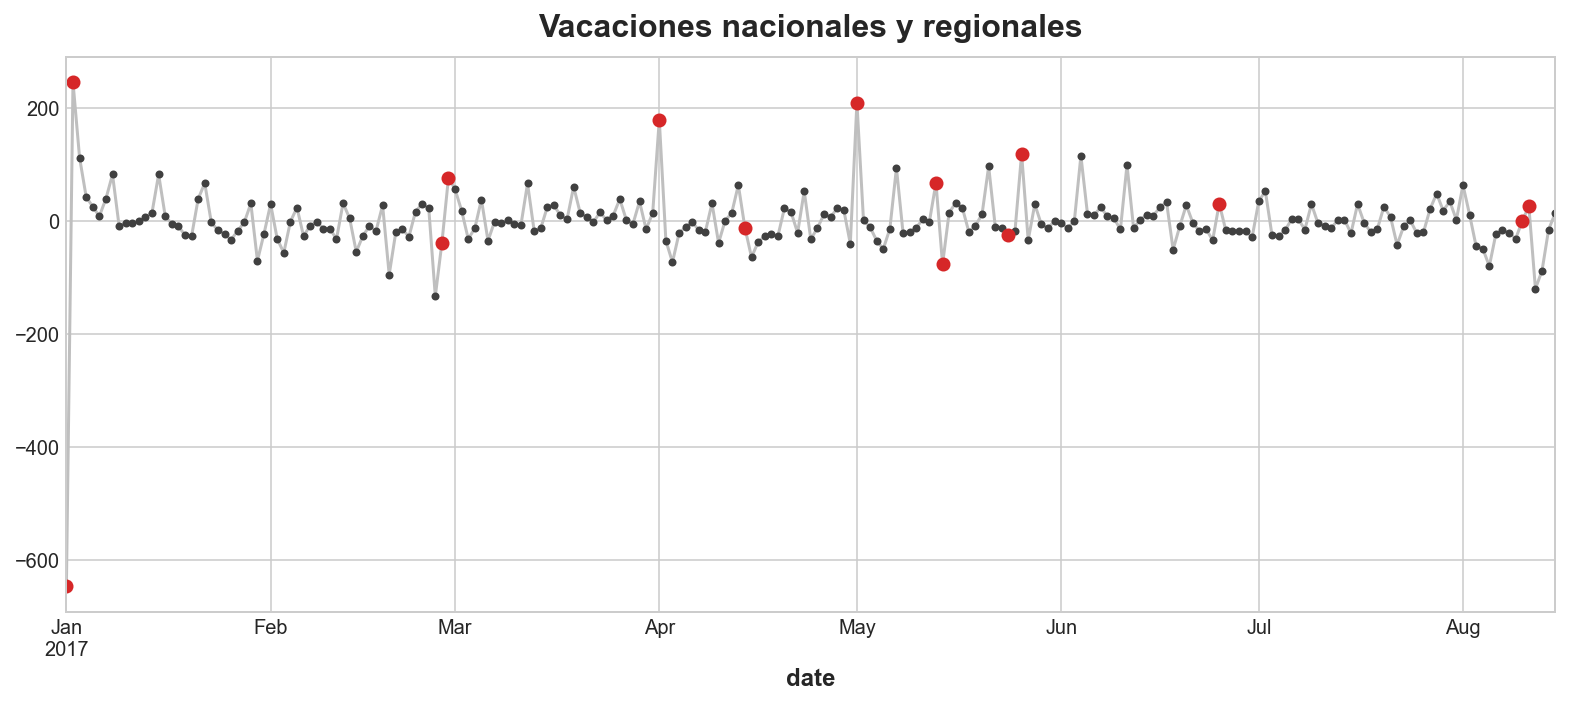

In [59]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('Vacaciones nacionales y regionales');

**¿Qué tipo de features podríamos crear para ayudar a nuestro modelo a hacer uso de esta información? Scikit-lear y Pandas tienen utilidades que permitirían hacer esto de forma fácil.**

In [60]:
# solución Scikit-learn
from sklearn.preprocessing import OneHotEncoder

one_hot = OneHotEncoder(sparse=False)

X_holidays = pd.DataFrame(
    one_hot.fit_transform(holidays),
    index=holidays.index,
    columns=holidays.description.unique(),
)

X_holidays.head()

,Primer dia del ano,Traslado Primer dia del ano,Carnaval,Provincializacion de Cotopaxi,Viernes Santo,Dia del Trabajo,Dia de la Madre-1,Dia de la Madre,Batalla de Pichincha,Traslado Batalla de Pichincha,Provincializacion de Imbabura,Primer Grito de Independencia,Traslado Primer Grito de Independencia
date,,,,,,,,,,,,,
2017-01-01,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-02-27,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-02-28,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [61]:
# solución Pandas
X_holidays = pd.get_dummies(holidays)

X_holidays.head()

,description_Batalla de Pichincha,description_Carnaval,description_Dia de la Madre,description_Dia de la Madre-1,description_Dia del Trabajo,description_Primer Grito de Independencia,description_Primer dia del ano,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,
2017-01-01,0,0,0,0,0,0,1,0,0,0,0,0,0
2017-01-02,0,0,0,0,0,0,0,0,0,0,0,1,0
2017-02-27,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-02-28,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-04-01,0,0,0,0,0,0,0,1,0,0,0,0,0


In [62]:
# Unión a los datos de entrenamiento
X2 = X.join(X_holidays, on='date').fillna(0.0)

X2.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,description_Dia de la Madre-1,description_Dia del Trabajo,description_Primer Grito de Independencia,description_Primer dia del ano,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Vamos a entrenar el modelo estacional con las features de vacaciones añadidas. **¿Los valores ajustados parecen haber mejorado?**

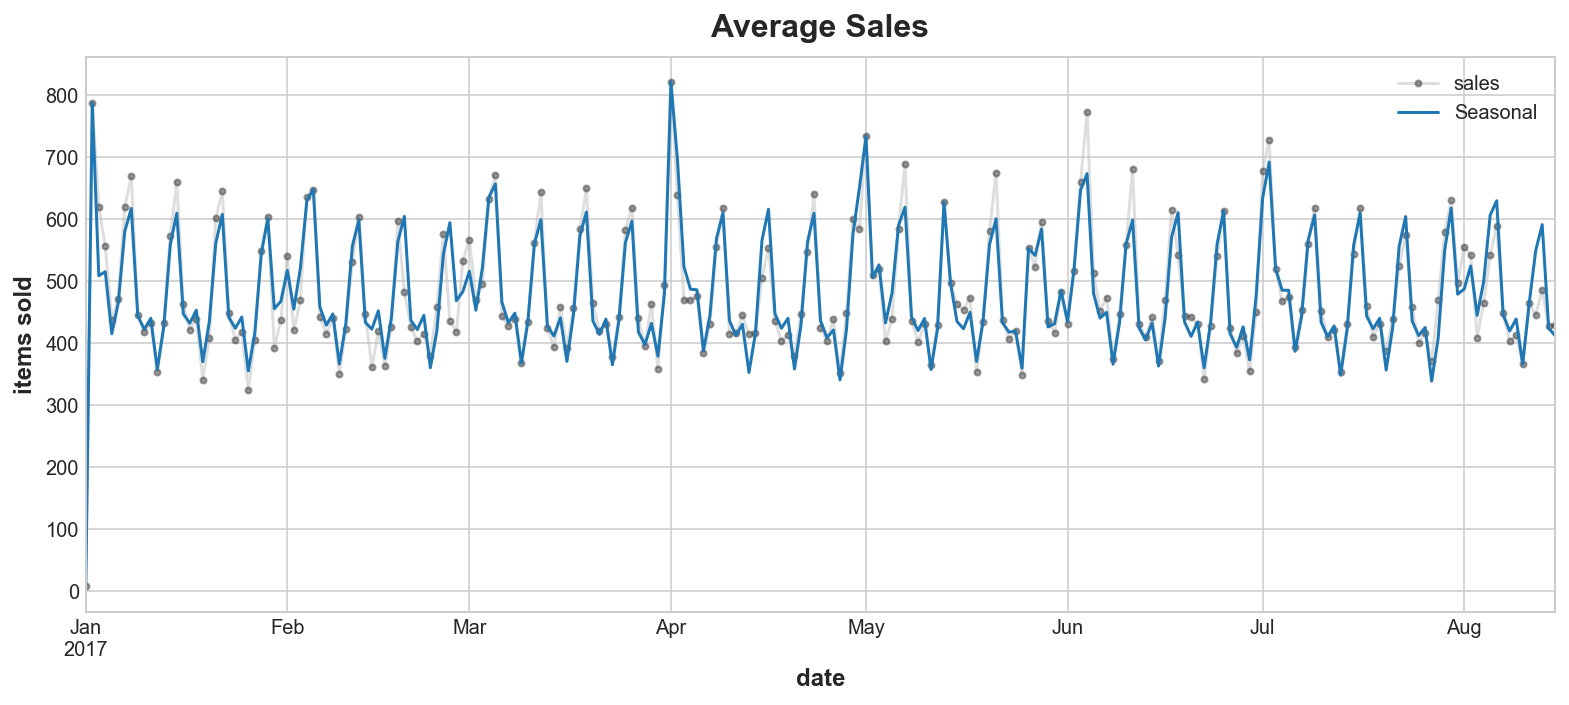

In [63]:
model = LinearRegression().fit(X2, y)

y_pred = pd.Series(model.predict(X2), index=X2.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

El modelo ha mejorado las predicciones en los días festivos.